In [174]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb

In [152]:
%matplotlib inline
pd.options.display.float_format ='{:,.3f}'.format
%config InlineBackend.figure_format = 'svg' 

In [247]:
train_data = pd.read_csv('data/train.csv')
train_data

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,"482,087.000",NaN,0.000,11.000,26.300,"685,960.000",1.000,NaN,1.000,debt consolidation,Short Term,"99,999,999.000","47,386.000","7,914.000",749.000,0
1,Own Home,"1,025,487.000",10+ years,0.000,15.000,15.300,"1,181,730.000",0.000,NaN,0.000,debt consolidation,Long Term,"264,968.000","394,972.000","18,373.000",737.000,1
2,Home Mortgage,"751,412.000",8 years,0.000,11.000,35.000,"1,182,434.000",0.000,NaN,0.000,debt consolidation,Short Term,"99,999,999.000","308,389.000","13,651.000",742.000,0
3,Own Home,"805,068.000",6 years,0.000,8.000,22.500,"147,400.000",1.000,NaN,1.000,debt consolidation,Short Term,"121,396.000","95,855.000","11,338.000",694.000,0
4,Rent,"776,264.000",8 years,0.000,13.000,13.600,"385,836.000",1.000,NaN,0.000,debt consolidation,Short Term,"125,840.000","93,309.000","7,180.000",719.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,"402,192.000",< 1 year,0.000,3.000,8.500,"107,866.000",0.000,NaN,0.000,other,Short Term,"129,360.000","73,492.000","1,900.000",697.000,0
7496,Home Mortgage,"1,533,984.000",1 year,0.000,10.000,26.500,"686,312.000",0.000,43.000,0.000,debt consolidation,Long Term,"444,048.000","456,399.000","12,783.000","7,410.000",1
7497,Rent,"1,878,910.000",6 years,0.000,12.000,32.100,"1,778,920.000",0.000,NaN,0.000,buy a car,Short Term,"99,999,999.000","477,812.000","12,479.000",748.000,0
7498,Home Mortgage,NaN,NaN,0.000,21.000,26.500,"1,141,250.000",0.000,NaN,0.000,debt consolidation,Short Term,"615,274.000","476,064.000","37,118.000",NaN,0


In [262]:
def prepare_data(data):
    #prepared_data = pd.DataFrame()
    #prepared_data = pd.get_dummies(train_data.loc[:,['Home Ownership', 'Purpose']], prefix=['ho', 'p'], columns = ['Home Ownership', 'Purpose'], drop_first=False)
    prepared_data = pd.get_dummies(data, prefix=['ho', 'p'], columns = ['Home Ownership', 'Purpose'], drop_first=False)
    transform_dict = {'< 1 year':0.5, '10+ years':10, '2 years':2, '3 years':3, '5 years':5, '1 year':1, '4 years':4, '6 years':6, '7 years':7, '8 years':8, '9 years':9}
    prepared_data['Years in current job'] = data['Years in current job'].replace(transform_dict, None)
    transform_dict = {'Long Term':0, 'Short Term':1}
    prepared_data['Term'] = data['Term'].replace(transform_dict, None)
    prepared_data['Current Loan Amount'] = data['Current Loan Amount'].replace(99999999, np.nan)
    prepared_data['Credit Score'] = data['Credit Score'].apply(lambda x: x/10 if x>1000 else x)
    prepared_data = prepared_data.drop('Months since last delinquent', axis=1)
    prepared_data['Tax Liens'] = data['Tax Liens'].apply(lambda x: 0 if x == 0 else 1)
    prepared_data['Number of Credit Problems'] = data['Number of Credit Problems'].apply(lambda x: 0 if x == 0 else 1)
    prepared_data['Bankruptcies'] = data['Bankruptcies'].apply(lambda x: 0 if x == 0 else 1)

    return prepared_data

In [274]:
train_data_prepared = prepare_data(train_data)
train_data_prepared.iloc[:,:13].describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,"5,943.000","7,129.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","6,630.000","7,500.000","7,500.000","5,943.000"
mean,"1,366,391.720",5.920,0.018,11.131,18.317,"945,153.727",0.137,0.112,0.741,"309,024.390","289,833.235","18,314.454",720.087
std,"845,339.200",3.558,0.132,4.909,7.042,"16,026,216.671",0.344,0.315,0.438,"182,294.009","317,871.382","11,926.765",27.957
min,"164,597.000",0.500,0.000,2.000,4.000,0.000,0.000,0.000,0.000,"11,242.000",0.000,0.000,585.000
25%,"844,341.000",3.000,0.000,8.000,13.500,"279,229.500",0.000,0.000,0.000,"172,744.000","114,256.500","10,067.500",708.000
50%,"1,168,386.000",6.000,0.000,10.000,17.000,"478,159.000",0.000,0.000,1.000,"265,826.000","209,323.000","16,076.500",729.000
75%,"1,640,137.000",10.000,0.000,14.000,21.800,"793,501.500",0.000,0.000,1.000,"430,100.000","360,406.250","23,818.000",740.000
max,"10,149,344.000",10.000,1.000,43.000,57.700,"1,304,726,170.000",1.000,1.000,1.000,"789,030.000","6,506,797.000","136,679.000",751.000


In [264]:
def fill_na(data):
    prepared_data = data
    prepared_data['Annual Income'] = data['Annual Income'].fillna(data['Annual Income'].mean())
    prepared_data['Current Loan Amount'] = data['Current Loan Amount'].fillna(data['Current Loan Amount'].mean())
    prepared_data['Credit Score'] = data['Credit Score'].fillna(data['Credit Score'].mean())
    prepared_data['Years in current job'] = data['Years in current job'].fillna(0)
    prepared_data['Bankruptcies'] = data['Bankruptcies'].fillna(data['Number of Credit Problems'].apply(lambda x: 0 if (x == 0) else 1))  
    return prepared_data

In [275]:
train_data_prepared = fill_na(train_data_prepared)
train_data_prepared.iloc[:,:13].describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,"7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000"
mean,"1,366,391.720",5.627,0.018,11.131,18.317,"945,153.727",0.137,0.112,0.741,"309,024.390","289,833.235","18,314.454",720.087
std,"752,481.202",3.699,0.132,4.909,7.042,"16,026,216.671",0.344,0.315,0.438,"171,393.650","317,871.382","11,926.765",24.886
min,"164,597.000",0.000,0.000,2.000,4.000,0.000,0.000,0.000,0.000,"11,242.000",0.000,0.000,585.000
25%,"931,133.000",2.000,0.000,8.000,13.500,"279,229.500",0.000,0.000,0.000,"180,169.000","114,256.500","10,067.500",715.000
50%,"1,366,391.720",6.000,0.000,10.000,17.000,"478,159.000",0.000,0.000,1.000,"309,024.390","209,323.000","16,076.500",720.087
75%,"1,499,974.000",10.000,0.000,14.000,21.800,"793,501.500",0.000,0.000,1.000,"396,929.500","360,406.250","23,818.000",738.000
max,"10,149,344.000",10.000,1.000,43.000,57.700,"1,304,726,170.000",1.000,1.000,1.000,"789,030.000","6,506,797.000","136,679.000",751.000


In [276]:
def parameter_fit(parameter):
    pp = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    return pp.fit(np.array(parameter).reshape(-1, 1)) 

def preprocessing_data_fit(data):
    fits = {}  
    #fits['Years of Credit History'] = parameter_fit(data['Years of Credit History'])
    #fits['Number of Open Accounts'] = parameter_fit(data['Number of Open Accounts'])
    pt = preprocessing.PowerTransformer(method='box-cox', standardize=True)
    fits['Annual Income'] = pt.fit(np.array(data['Annual Income']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Number of Open Accounts'] = pt.fit(np.array(data['Number of Open Accounts']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Years of Credit History'] = pt.fit(np.array(data['Years of Credit History']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Current Loan Amount'] = pt.fit(np.array(data['Current Loan Amount']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)  
    fits['Current Credit Balance'] = pt.fit(np.array(data['Current Credit Balance']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Monthly Debt'] = pt.fit(np.array(data['Monthly Debt']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Credit Score'] = pt.fit(np.array(data['Credit Score']).reshape(-1, 1))
    ss = preprocessing.StandardScaler()
    fits['Years in current job'] = ss.fit(np.array(data['Years in current job']).reshape(-1, 1))
    qt = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
    fits['Maximum Open Credit'] = qt.fit(np.array(train_data_prepared['Maximum Open Credit']).reshape(-1, 1))

    return fits

In [277]:
def preprocessing_data_transform(data, fits):
    prepared_data = data   
    for key in fits:
        print(key)
        prepared_data[key] = pd.DataFrame(fits[key].transform(np.array(data[key]).reshape(-1, 1)))
    return prepared_data

In [278]:
fits = preprocessing_data_fit(train_data_prepared)
train_data_prepared = preprocessing_data_transform(train_data_prepared, fits)

Annual Income
Number of Open Accounts
Years of Credit History
Current Loan Amount
Current Credit Balance
Monthly Debt
Credit Score
Years in current job
Maximum Open Credit


In [279]:
train_data_prepared.iloc[:,:13].describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,"7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000"
mean,0.000,0.000,0.018,-0.000,0.000,-0.022,0.137,0.112,0.741,0.000,0.000,0.000,-0.000
std,1.000,1.000,0.132,1.000,1.000,1.082,0.344,0.315,0.438,1.000,1.000,1.000,1.000
min,-4.214,-1.521,0.000,-3.015,-3.489,-5.199,0.000,0.000,0.000,-3.036,-3.370,-3.781,-2.372
25%,-0.581,-0.981,0.000,-0.569,-0.634,-0.674,0.000,0.000,0.000,-0.689,-0.593,-0.636,-0.508
50%,0.237,0.101,0.000,-0.078,-0.032,-0.000,0.000,0.000,1.000,0.168,-0.028,0.000,-0.269
75%,0.436,1.182,0.000,0.713,0.636,0.674,0.000,0.000,1.000,0.634,0.572,0.630,0.816
max,4.593,1.182,1.000,3.758,3.402,5.199,1.000,1.000,1.000,2.191,6.055,4.926,1.901


<AxesSubplot:>

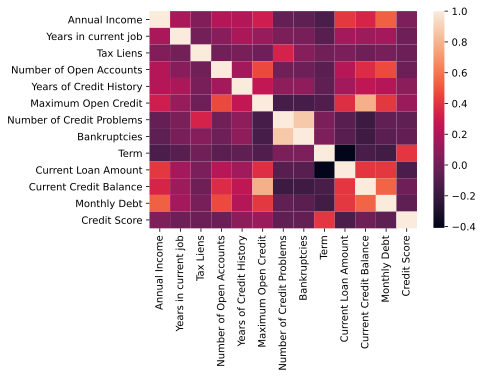

In [283]:
sns.heatmap(train_data_prepared.iloc[:,:13].corr())

In [ ]:
#pipe = make_pipeline(StandardScaler(), LogisticRegression())
#pipe.fit(X_train, y_train)

## Обучение

In [284]:
target = 'Credit Default'

In [300]:
X = np.array(train_data_prepared.iloc[:, train_data_prepared.columns != target])
X.shape

(7500, 32)

In [301]:
y = train_data_prepared[target].astype(int)
y.shape

(7500,)

In [302]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [307]:
y_test.shape

(1500,)

In [312]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size=0.20, random_state=1)

In [318]:
d_x_test = xgb.DMatrix(X_test)
d_train_val = xgb.DMatrix(X_train_validation, label=y_train_validation)
d_train = xgb.DMatrix(X_train, label=y_train)
d_val = xgb.DMatrix(X_validation, label=y_validation)

In [328]:
param = {'max_depth': 2, 'eta': 0.33, 'objective': 'binary:logistic'}
param['eval_metric'] = 'auc'

In [332]:
xgb.cv(param, d_train_val, 20, nfold=5,
       metrics={'auc'}, seed=0,
       callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])

[0]	train-auc:0.62732+0.00485	test-auc:0.62097+0.01888
[1]	train-auc:0.64352+0.01081	test-auc:0.63553+0.01736
[2]	train-auc:0.67655+0.01228	test-auc:0.65888+0.02001
[3]	train-auc:0.68751+0.00788	test-auc:0.66599+0.02040
[4]	train-auc:0.69799+0.00588	test-auc:0.67882+0.01442
[5]	train-auc:0.70515+0.00455	test-auc:0.68707+0.01712
[6]	train-auc:0.71090+0.00620	test-auc:0.69025+0.01339
[7]	train-auc:0.71722+0.00472	test-auc:0.69209+0.01571
[8]	train-auc:0.71950+0.00426	test-auc:0.69304+0.01980
[9]	train-auc:0.72439+0.00227	test-auc:0.69633+0.01752
[10]	train-auc:0.72760+0.00288	test-auc:0.69832+0.01837
[11]	train-auc:0.73054+0.00171	test-auc:0.69751+0.01802
[12]	train-auc:0.73295+0.00214	test-auc:0.69736+0.01723
[13]	train-auc:0.73448+0.00207	test-auc:0.69938+0.01639
[14]	train-auc:0.73599+0.00222	test-auc:0.70009+0.01563
[15]	train-auc:0.73887+0.00210	test-auc:0.70100+0.01408
[16]	train-auc:0.74096+0.00253	test-auc:0.70078+0.01555
[17]	train-auc:0.74289+0.00246	test-auc:0.70166+0.01575
[1

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.627,0.005,0.621,0.019
1,0.644,0.011,0.636,0.017
2,0.677,0.012,0.659,0.020
3,0.688,0.008,0.666,0.020
4,0.698,0.006,0.679,0.014
5,0.705,0.005,0.687,0.017
6,0.711,0.006,0.690,0.013
7,0.717,0.005,0.692,0.016
8,0.720,0.004,0.693,0.020
9,0.724,0.002,0.696,0.018


In [333]:
evallist = [(d_val, 'eval'), (d_train, 'train')]


bst = xgb.train(param, d_train, 100, evallist, early_stopping_rounds=10)
bst.save_model('0001.model')


[0]	eval-auc:0.63841	train-auc:0.62204
[1]	eval-auc:0.67323	train-auc:0.64450
[2]	eval-auc:0.68197	train-auc:0.65752
[3]	eval-auc:0.71129	train-auc:0.68432
[4]	eval-auc:0.71855	train-auc:0.68965
[5]	eval-auc:0.72644	train-auc:0.69488
[6]	eval-auc:0.71909	train-auc:0.70335
[7]	eval-auc:0.72471	train-auc:0.71033
[8]	eval-auc:0.72560	train-auc:0.71287
[9]	eval-auc:0.73201	train-auc:0.71988
[10]	eval-auc:0.73481	train-auc:0.72111
[11]	eval-auc:0.73279	train-auc:0.72064
[12]	eval-auc:0.73595	train-auc:0.72472
[13]	eval-auc:0.73754	train-auc:0.72835
[14]	eval-auc:0.73597	train-auc:0.73138
[15]	eval-auc:0.73623	train-auc:0.73196
[16]	eval-auc:0.73591	train-auc:0.73351
[17]	eval-auc:0.73473	train-auc:0.73561
[18]	eval-auc:0.73516	train-auc:0.73681
[19]	eval-auc:0.73404	train-auc:0.73816
[20]	eval-auc:0.73372	train-auc:0.73947
[21]	eval-auc:0.73478	train-auc:0.74044
[22]	eval-auc:0.73341	train-auc:0.74204
[23]	eval-auc:0.73392	train-auc:0.74381
[24]	eval-auc:0.73336	train-auc:0.74538
[25]	eval-

In [334]:
ypred = bst.predict(d_x_test, iteration_range=(0, bst.best_iteration))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

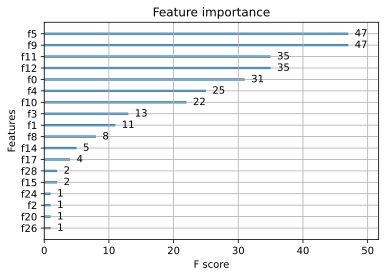

In [335]:
xgb.plot_importance(bst)

In [295]:
threshold = 0.5
predictions = [1 if val > threshold else 0 for val in ypred]
print(f1_score(y_test, predictions, average='binary'))
print(roc_auc_score(predictions, y_test))
print(confusion_matrix(predictions, y_test))
print(accuracy_score(predictions, y_test))

0.34190620272314676
0.6145740388072821
[[952 310]
 [125 113]]
0.71


In [296]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
# Загружаем алгоритмы модели
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

# оцениваем модель на каждой итерации
results = []
names = []

for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.153443 (0.028923)
LDA: 0.169727 (0.031575)
KNN: 0.257765 (0.047016)
CART: 0.366056 (0.036965)
NB: 0.165418 (0.154466)
SVM: 0.000000 (0.000000)


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [37]:
%%time
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(solver="warn"), parameters)
grid_search.fit(x_train, y_train)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

D:\git\project2\ml\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\git\project2\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\git\project2\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\git\project2\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got warn.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\git\project2\ml\lib\site-packages\sklearn\model_se

D:\git\project2\ml\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\git\project2\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\git\project2\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\git\project2\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got warn.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\git\project2\ml\lib\site-packages\sklearn\model_se

ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got warn.

In [297]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
def dummy_score(strategy_):
    clf_dummy = DummyClassifier(strategy = strategy_)
    clf_dummy.fit(X_train, y_train)
    ypred = clf_dummy.predict(X_test)
    print(f'{strategy_}:')
    print(f'f1_score: {f1_score(y_test, ypred, average="binary")}')
    print(f'roc_auc: {roc_auc_score(ypred, y_test)}')
    print(confusion_matrix(ypred, y_test))
    print()

dummy_score('uniform')
dummy_score('stratified')

uniform:
f1_score: 0.35037720033528913
roc_auc: 0.48913894324853224
[[516 214]
 [561 209]]

stratified:
f1_score: 0.28640192539109505
roc_auc: 0.5066391941391941
[[788 304]
 [289 119]]



In [99]:
clf_dummy.fit(X_train, y_train)
ypred = clf_dummy.predict(X_test)

In [100]:
threshold = 0.5
predictions = [1 if val > threshold else 0 for val in ypred]
print(f1_score(y_test, predictions, average='binary'))
print(roc_auc_score(predictions, y_test))
print(confusion_matrix(predictions, y_test))
print(accuracy_score(predictions, y_test))

0.0


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, verbose=1)
rf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    5.2s finished


RandomForestClassifier(n_estimators=1000, verbose=1)

In [43]:
ypred = rf.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [45]:
ypred.T

array([1, 1, 1, ..., 1, 1, 1])

In [83]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score